# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.noise = False # noise is for quantum, not classical
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250820-21-59-10 - 21-59-10


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 3 qubits needed for 4 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation,
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    if sdl.mode == 8:
        #input is all zeros
        unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    elif sdl.mode == 9:
        #input is 0.5
        unrepeated_input = torch.full((1,sdl.qubits), 0.5).float().to(device)

    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 3])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 3])


Set up model with gradient required:

In [11]:
model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 48 parameters in total, of which 48 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True
Parameter fc3.weight requires_grad: True
Parameter fc3.bias requires_grad: True
Parameter fc4.weight requires_grad: True
Parameter fc4.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

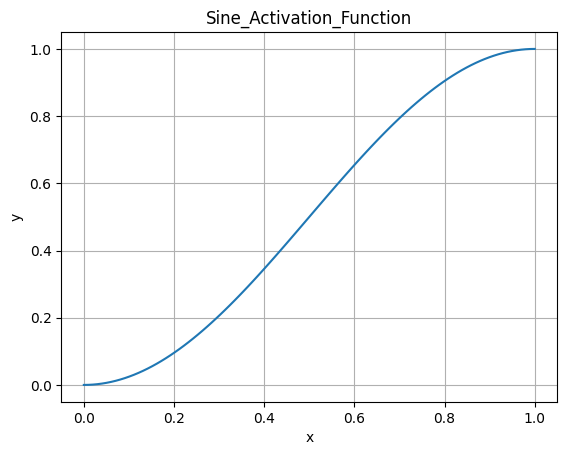

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[-0.5471,  0.2137, -0.5663],
        [-0.2692,  0.0578, -0.5424],
        [ 0.2369, -0.1892,  0.5152]], device='cuda:0', requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.2609, -0.4954,  0.1972], device='cuda:0', requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[-0.3376,  0.0326, -0.0803],
        [ 0.5515, -0.3112, -0.3120],
        [ 0.1968,  0.0371,  0.2845]], device='cuda:0', requires_grad=True), 'fc2.bias': Parameter containing:
tensor([-0.5263,  0.4622,  0.4048], device='cuda:0', requires_grad=True), 'fc3.weight': Parameter containing:
tensor([[-0.3769, -0.5231,  0.4089],
        [-0.2046,  0.4801,  0.4564],
        [-0.0032, -0.0865,  0.3424]], device='cuda:0', requires_grad=True), 'fc3.bias': Parameter containing:
tensor([-0.3982,  0.3287,  0.1171], device='cuda:0', requires_grad=True), 'fc4.weight': Parameter containing:
tensor([[ 0.0702,  0.4129,  0.5246],
        [-0.1612,  0.4551, -0.4713],
       

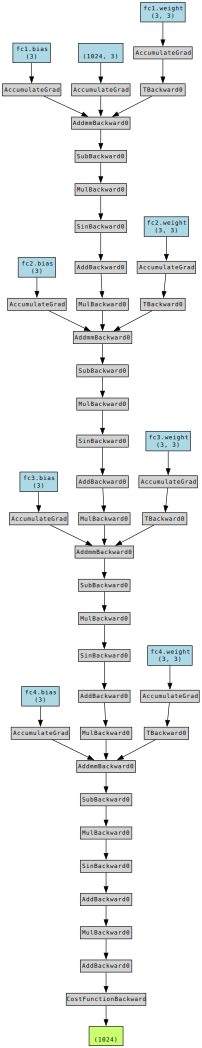

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 21.586 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 916.28
Epoch 0, fc2.weight grad: 1542.46
Epoch 0, fc2.bias grad: 2932.72
Epoch 0, fc3.weight grad: 2255.03
Epoch 0, fc3.bias grad: 2729.13
Epoch 0, fc4.weight grad: 2937.73
Epoch 0, fc4.bias grad: 3306.70
The time taken to run the code is 40.485 seconds
Saving data to results\results.csv
Detailed data for Run ID: 20250820-21-59-10 - 21-59-10 successfully added to results\20250820-21-59-10\21-59-10.csv


In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 21.000 at epoch 0.
The best known cost is 21.000


Plot loss ratio by epoch:

Graph for Run ID: 20250820-21-59-10-21-59-10 being saved to graphs\20250820-21-59-10\21-59-10.png


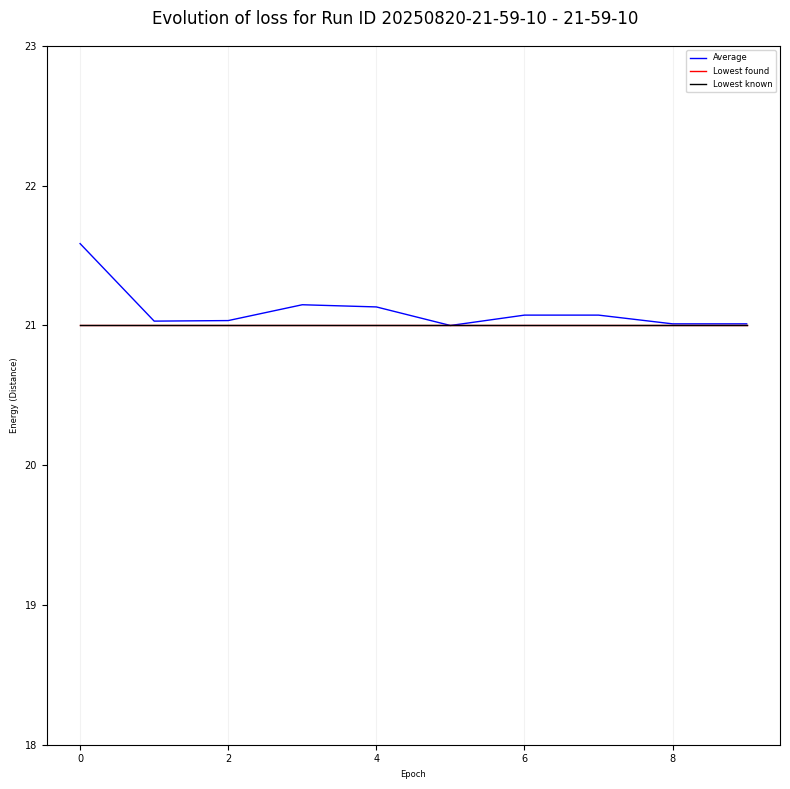

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[-0.5471,  0.2137, -0.5663],
        [-0.2692,  0.0578, -0.5424],
        [ 0.2369, -0.1892,  0.5152]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([-0.2942, -0.4405,  0.1390], device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[-0.3564, -0.0409, -0.0951],
        [ 0.5543, -0.2825, -0.3057],
        [ 0.1705, -0.0586,  0.2655]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([-0.6683,  0.5117,  0.2173], device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[-0.4688, -0.5533,  0.3087],
        [-0.2599,  0.4553,  0.3980],
        [ 0.0272, -0.0695,  0.3631]], device='cuda:0', requires_grad=True)
bias: Parameter containing:
tensor([-0.5748,  0.2250,  0.1643], device='cuda:0', requires_grad=True)
weight: Parameter containing:
tensor([[ 0.0880,  0.3985,  0.5224],
        [-0.1956,  0.4191, -0.4800],
        [-0.4701, -0.0079, -0.1445]], device='cuda:0', r